In  a docker terminal run
jupyter notebook --ip=0.0.0.0 --port=8888 --no-browser --allow-root

then open jupyter in the printed link (such as http://127.0.0.1:8888/tree?token=4d9d578397aede50fc5bd2d92794b562a6bbcbc73b2dfe51)

CODE HERE, REFRESH AND EXECUTE IN THE BROWSER

In [29]:
import os
import sys
import django

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


In [30]:
sys.path.append('/app')

os.environ['DJANGO_SETTINGS_MODULE'] = 'app.settings'
os.environ['PYTHONPATH'] = '/app'

django.setup()

In [153]:
from toolbox import models
from toolbox import views
from django.forms.models import model_to_dict
import numpy as np
import json
from django.contrib.gis.geos import GEOSGeometry, Polygon, MultiPolygon
from django.db.models import Q
from buek import models as b_m
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform, transform_geom
from rasterio.mask import mask
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt

In [249]:
suitability_dict = {
    'hydraulic_conductivity': {
        'mapping': {
            'conductivity_lt_5': {'map_value': 10, 'default_score': 0.2, 'score': 1},
            'conductivity_20_to_30': {'map_value': 200, 'default_score': 0.8, 'score': 4},
            'conductivity_gt_30': {'map_value': 300, 'default_score': 1.0, 'score': 5},
            'conductivity_5_to_10': {'map_value': 50, 'default_score': 0.4, 'score': 2},
            'conductivity_10_to_20': {'map_value': 100, 'default_score': 0.6, 'score': 3}
            }, 
        'map_path': './mar_raster_files/hydraulic_conductivity_classified_v1.tif', 
        'weight': 1.0
        }, 
        'land_use': {
            'mapping': {
                'forest_closed_coniferous': {'map_value': 111, 'default_score': 1.0, 'score': 5},
                'urban': {'map_value': 50, 'default_score': 0.0, 'score': 0},
                'permanent_waterbodies': {'map_value': 80, 'default_score': 0.0, 'score': 0},
                'herbaceous_wetland': {'map_value': 90, 'default_score': 0.0, 'score': 0},
                'forest_closed_deciduous': {'map_value': 114, 'default_score': 1.0, 'score': 5},
                'forest_closed_mixed': {'map_value': 115, 'default_score': 1.0, 'score': 5},
                'forest_closed_unknown': {'map_value': 116, 'default_score': 1.0, 'score': 5},
                'forest_open_coniferous': {'map_value': 121, 'default_score': 1.0, 'score': 5},
                'forest_open_deciduous': {'map_value': 124, 'default_score': 1.0, 'score': 5},
                'forest_open_mixed': {'map_value': 125, 'default_score': 1.0, 'score': 5},
                'forest_open_unknown': {'map_value': 126, 'default_score': 1.0, 'score': 5},
                'shrubs': {'map_value': 20, 'default_score': 0.8, 'score': 4},
                'herbaceous_vegetation': {'map_value': 30, 'default_score': 0.8, 'score': 5},
                'cropland': {'map_value': 40, 'default_score': 0.4, 'score': 2}
            }, 
            'map_path': './mar_raster_files/land_use.tif', 
            'weight': 1.0
        }, 
        'aquifer_thickness': {
            'mapping': {
                'thickness_20_to_30': {'map_value': 20, 'default_score': 0.4, 'score': 2},
                'thickness_30_to_40': {'map_value': 30, 'default_score': 0.6, 'score': 3},
                'thickness_40_to_60': {'map_value': 40, 'default_score': 0.8, 'score': 4},
                'thickness_gt_60': {'map_value': 60, 'default_score': 1.0, 'score': 5},
                'thickness_lt_20': {'map_value': 10, 'default_score': 0.2, 'score': 1}
            }, 'map_path': './mar_raster_files/aquifer_classified_v1.tif', 'weight': 1.0
        }, 
        'distance_to_well': {
            'mapping': {
                'zone_3': {'map_value': 20, 'default_score': 1.0, 'score': 5},
                'zone_1_and_2': {'map_value': 10, 'default_score': 0.0, 'score': 0},
                'well_catchment': {'map_value': 30, 'default_score': 0.8, 'score': 4},
                'out_of_catchment_lt_5km': {'map_value': 40, 'default_score': 0.6, 'score': 3},
                'out_of_catchment_gt_5km': {'map_value': 50, 'default_score': 0.4, 'score': 2}
            }, 
            'map_path': './mar_raster_files/distance_to_extraction_wells_v1.tif', 
            'weight': 1.0
        }, 
        'distance_to_source': {
            'mapping': {
                'distance_lt_250': {'map_value': 10, 'default_score': 0.0, 'score': 0},
                'distance_250_to_500': {'map_value': 20, 'default_score': 0.2, 'score': 1},
                'distance_500_to_800': {'map_value': 30, 'default_score': 1.0, 'score': 5},
                'distance_800_1200': {'map_value': 40, 'default_score': 0.8, 'score': 4},
                'distance_1200_to_1500': {'map_value': 50, 'default_score': 0.6, 'score': 3},
                'distance_gt_1500': {'map_value': 60, 'default_score': 0.4, 'score': 2}
            }, 
            'map_path': './mar_raster_files/distance_to_source_water_v1.tif', 
            'weight': 0.2
        }, 
        'depth_groundwater': {
            'mapping': {
                'depth_20_to_30': {'map_value': 20, 'default_score': 0.8, 'score': 4},
                'depth_30_to_40': {'map_value': 30, 'default_score': 0.6, 'score': 3},
                'depth_40_to_50': {'map_value': 40, 'default_score': 0.4, 'score': 2},
                'depth_gt_50': {'map_value': 50, 'default_score': 0.2, 'score': 1},
                'depth_lt_20': {'map_value': 10, 'default_score': 1.0, 'score': 5}
            }, 
            'map_path': './mar_raster_files/depth_to_gw_classified_v1.tif', 
            'weight': 1.0
        }
    }

In [282]:
with rasterio.open('mar_raster_files/aquifer_classified.tif', 'r') as ref:
    transform = ref.transform
    crs=ref.crs
    data = ref.read(1)
    nodata=ref.nodata

crs


CRS.from_wkt('PROJCS["ETRS89 / UTM zone 33N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25833"]]')

In [283]:
nogo = models.MarForbiddenArea.objects.first()
geojson = json.loads(nogo.geom25833.geojson)

In [284]:
ones = np.ones(data.shape)

In [285]:
mask_array = geometry_mask(
    [geojson],
    out_shape=(data.shape),
    transform=transform,
    invert=False  # False means inside polygon is True (masked)
)


In [286]:
mask_array

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(899, 732))

In [287]:
ones_and_zero = np.where(mask_array, 1, 0)

In [288]:
with rasterio.open(
    'mar_raster_files/nogo_area_mask.tif',
    'w',
    driver='GTiff',
    height=data.shape[0],
    width=data.shape[1],
    count=1,
    dtype=np.float32,
    crs=crs,
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(ones_and_zero, 1)

In [303]:
def compute_suitability_from_tifs(suitability_dict, user_field):
    
        # We'll prepare a destination array for each raster, stacked into 3D array
    
        # out_masked, out_transform = mask(ref, [user_field.geom25833.geojson], crop=False, invert=False, indexes=1, nodata=np.nan, filled=False)

    with rasterio.open('mar_raster_files/nogo_area_mask.tif') as mask:
        nogo_mask = mask.read(1)
        dst_crs = mask.crs
        dst_transform = mask.transform
        dst_width = mask.width
        dst_height = mask.height
        dst_profile = mask.profile.copy()

    dst_profile['nodata'] = np.nan

    length_stack = len(suitability_dict) + 1
    stack = np.zeros((length_stack, dst_height, dst_width), dtype=np.float32)
    weighted_stack = np.zeros((2, dst_height, dst_width), dtype=np.float32)

    stack[0] = nogo_mask
    weighted_stack[0] = nogo_mask


    mask_arr = None  # to store mask for polygon later
    layer_weight_sum = 0
    for key in suitability_dict:
        layer_weight_sum += suitability_dict[key]['weight']
        
    i = 1
    for key in suitability_dict:
        
        path = suitability_dict[key]['map_path']
        
        try:
            with rasterio.open(path) as src:
                dst_arr = src.read(1)
            
                dst_nodata = src.nodata
            new_arr = dst_arr.copy()
            new_arr = np.where(
               new_arr==dst_nodata,
               np.nan,
               new_arr
               )
            for k in suitability_dict[key]['mapping']:
                new_arr = np.where(
                    new_arr==float(suitability_dict[key]['mapping'][k]['map_value']),
                    suitability_dict[key]['mapping'][k]['score']/5,
                    new_arr
                    )
            stack[i] = new_arr
            weighted_stack[1] = weighted_stack[1] + (new_arr * suitability_dict[key]['weight'] / layer_weight_sum)
            
            i +=1
        except:
            print(path)
    result_2d = np.prod(weighted_stack, axis=0)

    with rasterio.open('mar_raster_files/result_2d.tif', 'w', **dst_profile) as f:

        f.write(result_2d.astype(np.float32),1)

    i = 0
    for key in suitability_dict:
        i += 1
        print(i)
        with rasterio.open(f'mar_raster_files/weighted_stack_{key}.tif', 'w', **dst_profile) as f:

            f.write(stack[i].astype(np.float32),1)
    

    return stack, weighted_stack, result_2d

In [36]:
user_field = models.UserField.objects.first()

In [304]:

tif_stack, result_2d, result_weighted = compute_suitability_from_tifs(suitability_dict, user_field)

1
2
3
4
5
6


In [275]:
result_weighted = np.prod(result_weighted, axis=0)

In [276]:
result_weighted.shape

(899, 732)

In [278]:
np.nanmax(result_weighted)

np.float32(1.0)

In [256]:
np.unique(result_2d)


array([0.00000000e+00, 3.84000014e-04, 5.12000057e-04, 6.40000042e-04,
       7.68000027e-04, 9.60000150e-04, 1.02400011e-03, 1.15200016e-03,
       1.28000008e-03, 1.53600005e-03, 1.53600017e-03, 1.53600029e-03,
       1.92000007e-03, 1.92000018e-03, 1.92000030e-03, 2.04800023e-03,
       2.30400008e-03, 2.30400031e-03, 2.30400055e-03, 2.56000017e-03,
       2.88000028e-03, 2.88000051e-03, 3.07200011e-03, 3.07200034e-03,
       3.07200057e-03, 3.20000015e-03, 3.45600047e-03, 3.45600070e-03,
       3.84000014e-03, 3.84000037e-03, 3.84000060e-03, 4.09600046e-03,
       4.60800016e-03, 4.60800063e-03, 4.60800109e-03, 4.80000023e-03,
       4.80000069e-03, 5.12000034e-03, 5.76000055e-03, 5.76000102e-03,
       6.14400022e-03, 6.14400068e-03, 6.14400115e-03, 6.40000030e-03,
       6.91200048e-03, 6.91200094e-03, 6.91200141e-03, 7.68000027e-03,
       7.68000074e-03, 7.68000120e-03, 8.00000038e-03, 8.19200091e-03,
       8.64000060e-03, 8.64000153e-03, 9.21600033e-03, 9.21600126e-03,
      

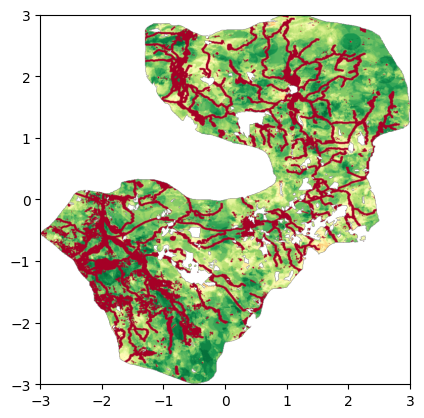

In [279]:
import matplotlib.cbook as cbook
import matplotlib.cm as cm

tbplotted = result_weighted

fig, ax = plt.subplots()
im = ax.imshow(tbplotted, interpolation='bilinear', cmap=cm.RdYlGn,
               origin='lower', extent=[-3, 3, -3, 3],
               vmax=1, vmin=0)


In [111]:
with rasterio.open('mar_raster_files/aquifer_classified.tif', 'r') as src:
    dst_arr = src.read(1)
    dst_nodata = src.nodata


In [179]:
tif_stack[0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], shape=(899, 732), dtype=float32)

In [108]:
new_arr = dst_arr.copy()
new_arr.dtype

dtype('float32')

In [118]:
unique_vals = np.unique(new_arr)
unique_vals

array([-3.4028235e+38,  1.0000000e+00,  2.0000000e+00,  3.0000000e+00,
        4.0000000e+00,  5.0000000e+00], dtype=float32)

In [88]:
suitability_dict['aquifer_thickness']['mapping']

{'tickness_lt_20': {'map_value': 0, 'default_score': 0.2, 'score': 1},
 'tickness_20_to_30': {'map_value': 20, 'default_score': 0.4, 'score': 2},
 'tickness_30_to_40': {'map_value': 30, 'default_score': 0.6, 'score': 3},
 'tickness_40_to_60': {'map_value': 40, 'default_score': 0.8, 'score': 4},
 'tickness_gt_60': {'map_value': 60, 'default_score': 1.0, 'score': 5}}

In [126]:
new_arr = np.where((new_arr==dst_nodata), np.nan, new_arr)

key = 'aquifer_thickness'
for k in suitability_dict[key]['mapping']:
    print("suitability_dict[key]['mapping'][k]['map_value']", suitability_dict[key]['mapping'][k]['map_value'])
    print("suitability_dict[key]['mapping'][k]['score']", suitability_dict[key]['mapping'][k]['score'])
    new_arr = np.where(
        new_arr==float(suitability_dict[key]['mapping'][k]['map_value']),
        suitability_dict[key]['mapping'][k]['score'],
        new_arr
        )
    

suitability_dict[key]['mapping'][k]['map_value'] 0
suitability_dict[key]['mapping'][k]['score'] 1
suitability_dict[key]['mapping'][k]['map_value'] 20
suitability_dict[key]['mapping'][k]['score'] 2
suitability_dict[key]['mapping'][k]['map_value'] 30
suitability_dict[key]['mapping'][k]['score'] 3
suitability_dict[key]['mapping'][k]['map_value'] 40
suitability_dict[key]['mapping'][k]['score'] 4
suitability_dict[key]['mapping'][k]['map_value'] 60
suitability_dict[key]['mapping'][k]['score'] 5


In [127]:
new_arr

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(899, 732), dtype=float32)